# Working with precipitation files in Python

You will need to:
- Import modules that are important to complete the work.
- Load the files and "understand" them.
- Join the files in a large matrix.
- Compute statistics.
- Save the files for later use.

Optionally:
- Create plots

### Do not forget to run all cells in order, from top to bottom. Failing to do so may cause errors.
### AI Large Language Models (such as deepseek) can help you a lot doing this.

## Modules

Some useful modules are:
- `pandas` (https://pandas.pydata.org/docs/getting_started/intro_tutorials/): to work with tabular data (including import and export). It is the "Microsoft Excel" of Python.
- `matplotlib` (https://matplotlib.org/stable/plot_types/index.html): to create figures (plots).
- `pathlib`: not as important. To handle folder and file paths.

Some syntax examples:
- `import pandas` (this imports the pandas module).
- `import pandas as pd` (this will allow you to write `pd` in your code instead of `pandas` - just more practical).
- `from pandas import read_csv` (this will allow you to import just the `read_csv` function and not the whole of `pandas`.
- `import matplotlib.pyplot as plt` (now we are importing a submodule of `matplotlib` (`pyplot`) as `plt`).
- `from matplotlib import pyplot as plt` (This is another way of doing it). 


## Import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

## Now let's read a CSV file
... and see what it looks like.

Specify where the file is with `Path`.  
`r'.\'` means the path is relative to where this file (the code) is.  
Read the file with `with open(...) as ... :`


In [2]:
file_path = Path(r'./Lab work/6606347/precipitation/UKE00105909.csv')

with open(file_path, 'r', encoding='utf-8') as file:
    for i, line in enumerate(file):
        print(line.rstrip())
        if i >= 10:
            break

"STATION","DATE","LATITUDE","LONGITUDE","ELEVATION","NAME","PRCP","PRCP_ATTRIBUTES","TMAX","TMAX_ATTRIBUTES","TMIN","TMIN_ATTRIBUTES"
"UKE00105909","1959-12-31","52.2058","-1.6031","47.0","WELLESBOURNE, UK",,,"  111",",,E",,
"UKE00105909","1960-01-01","52.2058","-1.6031","47.0","WELLESBOURNE, UK",,,"   67",",I,E","   94",",I,E"
"UKE00105909","1960-01-02","52.2058","-1.6031","47.0","WELLESBOURNE, UK",,,"  106",",,E","   44",",,E"
"UKE00105909","1960-01-03","52.2058","-1.6031","47.0","WELLESBOURNE, UK",,,"  122",",,E","   56",",,E"
"UKE00105909","1960-01-04","52.2058","-1.6031","47.0","WELLESBOURNE, UK",,,"   78",",,E","   56",",,E"
"UKE00105909","1960-01-05","52.2058","-1.6031","47.0","WELLESBOURNE, UK",,,"   44",",I,E","   61",",I,E"
"UKE00105909","1960-01-06","52.2058","-1.6031","47.0","WELLESBOURNE, UK",,,"   11",",,E","  -11",",,E"
"UKE00105909","1960-01-07","52.2058","-1.6031","47.0","WELLESBOURNE, UK",,,"   39",",,E","  -17",",,E"
"UKE00105909","1960-01-08","52.2058","-1.6031","47

## Now let's read it with pandas

It is really this easy!

Check out the documentation here:
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [3]:
pd.read_csv(file_path)

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,PRCP,PRCP_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES
0,UKE00105909,1959-12-31,52.2058,-1.6031,47.0,"WELLESBOURNE, UK",NaN,NaN,111.0,",,E",NaN,NaN
1,UKE00105909,1960-01-01,52.2058,-1.6031,47.0,"WELLESBOURNE, UK",NaN,NaN,67.0,",I,E",94.0,",I,E"
2,UKE00105909,1960-01-02,52.2058,-1.6031,47.0,"WELLESBOURNE, UK",NaN,NaN,106.0,",,E",44.0,",,E"
3,UKE00105909,1960-01-03,52.2058,-1.6031,47.0,"WELLESBOURNE, UK",NaN,NaN,122.0,",,E",56.0,",,E"
4,UKE00105909,1960-01-04,52.2058,-1.6031,47.0,"WELLESBOURNE, UK",NaN,NaN,78.0,",,E",56.0,",,E"
...,...,...,...,...,...,...,...,...,...,...,...,...
23376,UKE00105909,2025-01-27,52.2058,-1.6031,47.0,"WELLESBOURNE, UK",48.0,",,E",89.0,",,E",38.0,",,E"
23377,UKE00105909,2025-01-28,52.2058,-1.6031,47.0,"WELLESBOURNE, UK",16.0,",,E",78.0,",,E",47.0,",,E"
23378,UKE00105909,2025-01-29,52.2058,-1.6031,47.0,"WELLESBOURNE, UK",0.0,",,E",79.0,",,E",21.0,",,E"
23379,UKE00105909,2025-01-30,52.2058,-1.6031,47.0,"WELLESBOURNE, UK",48.0,",,E",80.0,",,E",-4.0,",,E"


## We can provide more information to the reader too
I wish to use the date as the row index.  
To parse the dates correctly as `datetime64[ns]` we use the `pd.to_datetime` function.   
    You can find all about the format here: https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior   
We also want to discard all columns beyond PRCP (precipitation)

### Precipitation data from this source (GHCN-Daily) is stored in 0.1 mm/day. We must convert to mm/day.

In [4]:
my_data = pd.read_csv(file_path, index_col=1, usecols=[0, 1, 2, 3, 4, 5, 6])
my_data.index = pd.to_datetime(my_data.index, format='%Y-%m-%d', errors='coerce')
my_data.PRCP /= 10

station = my_data.iloc[0, 0]
print(f'This station is {station}')

my_data

This station is UKE00105909


,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,PRCP
DATE,,,,,,
1959-12-31,UKE00105909,52.2058,-1.6031,47.0,"WELLESBOURNE, UK",NaN
1960-01-01,UKE00105909,52.2058,-1.6031,47.0,"WELLESBOURNE, UK",NaN
1960-01-02,UKE00105909,52.2058,-1.6031,47.0,"WELLESBOURNE, UK",NaN
1960-01-03,UKE00105909,52.2058,-1.6031,47.0,"WELLESBOURNE, UK",NaN
1960-01-04,UKE00105909,52.2058,-1.6031,47.0,"WELLESBOURNE, UK",NaN
...,...,...,...,...,...,...
2025-01-27,UKE00105909,52.2058,-1.6031,47.0,"WELLESBOURNE, UK",4.8
2025-01-28,UKE00105909,52.2058,-1.6031,47.0,"WELLESBOURNE, UK",1.6
2025-01-29,UKE00105909,52.2058,-1.6031,47.0,"WELLESBOURNE, UK",0.0


## Let's see what the data looks like
Using matplotlib (included in pandas).  
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html

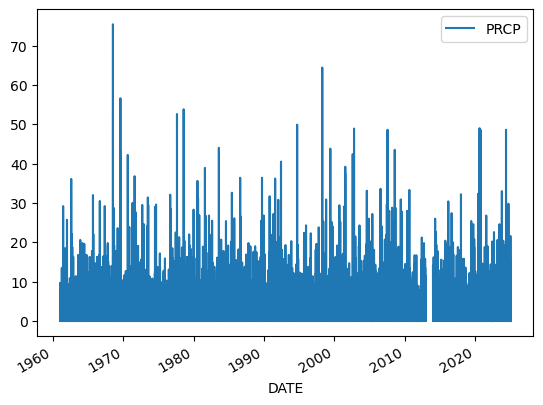

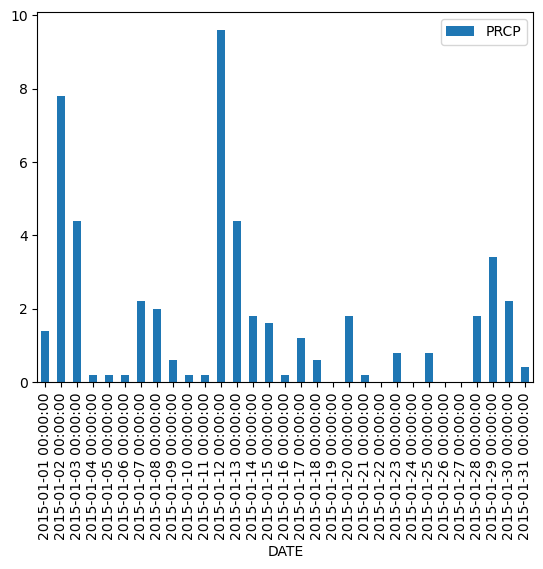

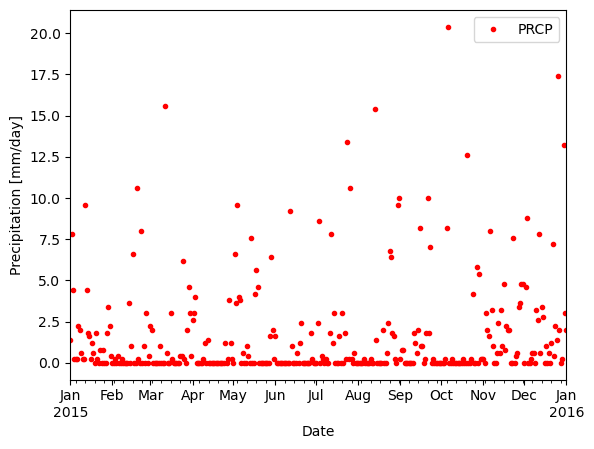

In [5]:
my_data.iloc[:, [-1]].plot()

my_data.loc['2015-01-01':'2015-01-31', ['PRCP']].plot(kind='bar')

ax = my_data.loc['2015-01-01':'2016-01-01', ['PRCP']].plot(linestyle=' ', marker='.', color='red')
_ = ax.set_xlabel('Date')
_ = ax.set_ylabel('Precipitation [mm/day]')


## Let's now aggregate to yearly
We can use the `pd.resample` function:   
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html

`my_data.loc[:, ['PRCP']].resample('YS-APR').sum(min_count=365)`  
This will focus on the "PRCP" column (`,loc()`)  
and resample based on a sum of all values on a yearly basis, with start in april `YS-APR` (just an example).  
Also, we do a sum that only returns values if there are at least 365 entries `.sum(min_count=365)`.  
Finally, all missing data are dropped (`.dropna()`).



In [6]:
yearly_data = my_data.loc[:, ['PRCP']].resample('YS-APR').sum(min_count=365).dropna()
yearly_data

,PRCP
DATE,
1961-04-01,542.9
1962-04-01,469.6
1963-04-01,530.4
1964-04-01,485.8
1965-04-01,664.4
1966-04-01,677.6
1968-04-01,749.4
1969-04-01,626.6
1970-04-01,593.6


## Let's compute statistics
We can use .agg

In [7]:
stats = yearly_data.agg(['mean', 'std', 'count', 'min', 'max', 'skew'])
stats.loc['cv'] = stats.loc['std'] / stats.loc['mean']
stats

,PRCP
mean,617.179310
std,115.300705
count,58.000000
min,353.700000
max,897.800000
skew,-0.161703
cv,0.186819


## Now let's join, change the header, and export to Excel

In [8]:
joint = pd.concat([yearly_data, stats], axis=0)
joint.columns = pd.MultiIndex.from_product([['Precipitation [mm/year]'], [station]], names=['Variable', 'Station'])

joint.to_excel(f'parsed_{station}.xlsx')

joint

Variable,Precipitation [mm/day]
Station,UKE00105909
1961-04-01 00:00:00,542.900000
1962-04-01 00:00:00,469.600000
1963-04-01 00:00:00,530.400000
1964-04-01 00:00:00,485.800000
1965-04-01 00:00:00,664.400000
...,...
count,58.000000
min,353.700000
max,897.800000


## Now the magic begins to happen...
Lets do this for all stations at once!

First, use `glob` to get all files with the `.csv` extension in the `precipitation` folder

In [13]:
folder_path = Path(r'./Lab work/6606347/precipitation')

for file in folder_path.glob('*.csv'):
    print(file)

Lab work\6606347\precipitation\UK000056225.csv
Lab work\6606347\precipitation\UKE00102158.csv
Lab work\6606347\precipitation\UKE00105869.csv
Lab work\6606347\precipitation\UKE00105909.csv
Lab work\6606347\precipitation\UKE00105911.csv
Lab work\6606347\precipitation\UKE00105915.csv
Lab work\6606347\precipitation\UKE00105922.csv
Lab work\6606347\precipitation\UKE00105923.csv
Lab work\6606347\precipitation\UKE00105924.csv
Lab work\6606347\precipitation\UKE00105925.csv
Lab work\6606347\precipitation\UKE00107650.csv
Lab work\6606347\precipitation\UKE00107962.csv
Lab work\6606347\precipitation\UKM00003740.csv
Lab work\6606347\precipitation\UKM00003772.csv
Lab work\6606347\precipitation\UKM00003862.csv


In [16]:
all_data = []
for file in folder_path.glob('*.csv'):
    station = file.name.replace('.csv','')
    _data = pd.read_csv(file, index_col=0, usecols=[1, 6])
    _data.index = pd.to_datetime(_data.index, format='%Y-%m-%d', errors='coerce')
    _data.PRCP /= 10

    _data = _data.loc[:, ['PRCP']].resample('YS-APR').sum(min_count=365).dropna()
    _data.columns = pd.MultiIndex.from_product([['Precipitation [mm/year]'], [station]], names=['Variable', 'Station'])
    
    all_data.append(_data)

full_dataset = pd.concat(all_data, axis=1)
full_dataset

Variable   Precipitation [mm/year]                                      \
Station                UK000056225 UKE00102158 UKE00105869 UKE00105909   
DATE                                                                     
1827-04-01                   600.3         NaN         NaN         NaN   
1828-04-01                   572.1         NaN         NaN         NaN   
1829-04-01                   570.4         NaN         NaN         NaN   
1830-04-01                   793.4         NaN         NaN         NaN   
1831-04-01                   680.6         NaN         NaN         NaN   
...                            ...         ...         ...         ...   
2019-04-01                   808.3      1008.8      1053.4       810.8   
2020-04-01                   828.4       805.4       839.4       703.8   
2021-04-01                     NaN       682.6       727.4       548.8   
2022-04-01                     NaN       798.2       802.2         NaN   
2023-04-01                     NaN      1187.4      1221.4       897.8   

Variable                                                                \
Station    UKE00105911 UKE00105915 UKE00105922 UKE00105923 UKE00105924   
DATE                                                                     
1827-04-01         NaN         NaN         NaN         NaN         NaN   
1828-04-01         NaN         NaN         NaN         NaN         NaN   
1829-04-01         NaN         NaN         NaN         NaN         NaN   
1830-04-01         NaN         NaN         NaN         NaN         NaN   
1831-04-01         NaN         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2019-04-01         NaN         NaN         NaN      1056.8         NaN   
2020-04-01         NaN         NaN         NaN         NaN         NaN   
2021-04-01         NaN         NaN         NaN         NaN         NaN   
2022-04-01         NaN         NaN         NaN       864.7         NaN   
2023-04-01         NaN         NaN         NaN      1218.0         NaN   

Variable                                                                \
Station    UKE00105925 UKE00107650 UKE00107962 UKM00003740 UKM00003772   
DATE                                                                     
1827-04-01         NaN         NaN         NaN         NaN         NaN   
1828-04-01         NaN         NaN         NaN         NaN         NaN   
1829-04-01         NaN         NaN         NaN         NaN         NaN   
1830-04-01         NaN         NaN         NaN         NaN         NaN   
1831-04-01         NaN         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2019-04-01         NaN       725.4       829.2         NaN       728.4   
2020-04-01         NaN       630.0       745.8         NaN         NaN   
2021-04-01         NaN       603.0       630.4         NaN         NaN   
2022-04-01         NaN       635.2       755.8         NaN       580.5   
2023-04-01         NaN       842.4       961.6         NaN         NaN   

Variable                
Station    UKM00003862  
DATE                    
1827-04-01         NaN  
1828-04-01         NaN  
1829-04-01         NaN  
1830-04-01         NaN  
1831-04-01         NaN  
...                ...  
2019-04-01         NaN  
2020-04-01         NaN  
2021-04-01         NaN  
2022-04-01         NaN  
2023-04-01         NaN  

[197 rows x 15 columns]

## Can you add the statistics and save to an Excel file?